In [181]:
import pandas as pd
import numpy as np
import plotly.express as px
from tinyshift.series import adi_cv, theoretical_limit, foreca, stability_index, hurst_exponent, trend_significance
from utilsforecast.preprocessing import fill_gaps
from utilsforecast.data import generate_series
from statsmodels.tsa.stattools import adfuller, acf, pacf
from tinyshift.plot import corr_heatmap
import holidays
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp

In [182]:
df = generate_series(3, with_trend=True, static_as_categorical=False, seed=42, freq="D")

In [183]:
df.isnull().sum()

unique_id    0
ds           0
y            0
dtype: int64

In [184]:
df = fill_gaps(df, freq="D", end="per_serie", id_col="unique_id", time_col="ds")

In [185]:
def remove_leading_zeros(group):
    """
    Removes leading zeros from series
    """
    first_non_zero_index = group["y"].ne(0).idxmax()
    return group.loc[first_non_zero_index:]

In [186]:
df = df.groupby("unique_id")[df.columns].apply(remove_leading_zeros).reset_index(drop=True)

In [187]:
def is_obsolete(group, days_obsoletes):
    """
    Identify obsolote series
    """
    last_date = group["ds"].max()
    cutoff_date = last_date - pd.Timedelta(days=days_obsoletes)
    recent_data = group[group["ds"] >= cutoff_date]
    return (recent_data["y"] ==0).all()

In [188]:
days_obsoletes=180
obsolete_series = df.groupby("unique_id")[df.columns].apply(is_obsolete, days_obsoletes)

In [189]:
obsolote_ids = obsolete_series[obsolete_series].index.tolist()

In [190]:
obsolote_ids

[]

In [191]:
df.groupby("unique_id")["y"].apply(trend_significance)

unique_id
0    (0.9894087777029937, 4.8574508252298796e-150)
1                         (0.998759437594496, 0.0)
2                        (0.9990776434701963, 0.0)
Name: y, dtype: object

In [192]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [193]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [194]:
def forecastability(X):
    """
    Calculate forecastability metrics for a time series.
    """
    return {"foreCA": foreca(X),
     "theoretical_limit": theoretical_limit(X),
     "stability_index": stability_index(X, detrend=True),
     "adi_cv": adi_cv(X),
     "hurst_exponent": hurst_exponent(X)}

In [195]:
df.groupby("unique_id")["y"].apply(forecastability)

unique_id                   
0          foreCA                                                  0.616734
           theoretical_limit                                       0.560748
           stability_index                                         0.937922
           adi_cv                                (1.0, 0.28499520299004516)
           hurst_exponent         (0.3290861603798452, 0.13218639190520123)
1          foreCA                                                  0.702415
           theoretical_limit                                        0.55557
           stability_index                                           0.9567
           adi_cv                                (1.0, 0.31390442751597913)
           hurst_exponent       (0.28893923895853546, 0.032089718874560705)
2          foreCA                                                  0.691794
           theoretical_limit                                       0.558174
           stability_index                                 

# ADF Test - Order of Diff 1

In [196]:
def add_diff_column(df, target_col="y", group_col="unique_id", d=1):
    """
    Adds a differenced column to the dataframe using pipe pattern
    """
    df = df.copy()
    
    # Calculate differences for each group
    diff_values = df.groupby(group_col)[target_col].apply(
        lambda x: np.concatenate([[np.nan] * d, np.diff(x, n=d)])
    )
    
    # Flatten the result and add as new column
    df[f'diff_{d}'] = np.concatenate(diff_values.values)
    
    return df.dropna()

In [203]:
# Using pipe pattern
df = df.pipe(add_diff_column, target_col="y", group_col="unique_id", d=1)

In [204]:
df.groupby("unique_id")["y"].apply(adfuller)

unique_id
0    (-0.15700200673021275, 0.9434565436254427, 13,...
1    (-0.03079118253617105, 0.9559103844711581, 13,...
2    (0.03165116493247041, 0.9610726460919334, 14, ...
Name: y, dtype: object

In [205]:
df.groupby("unique_id")["diff_1"].apply(adfuller)

unique_id
0    (-7.444901792916966, 5.873228658257597e-11, 12...
1    (-15.218809498073938, 5.522101966975081e-28, 1...
2    (-11.111036755832156, 3.6596729817864727e-20, ...
Name: diff_1, dtype: object

# Domingo

- #TODO: Adicionar gráfico de ACF
- #TODO: Adicionar gráfico de PACF
- #TODO: Adicionar gráfico de STL
- #TODO: Interpretar
- #TODO: Adicionar gráficos da aula do valeriy
- #TODO: Comparativo de dados diferenciados
- #TODO: Trazer gráficos de ipynbs dele

In [206]:
def create_acf_pacf_traces(data, nlags=30, color='blue'):
    n = len(data)
    conf = 1.96 / np.sqrt(n)
    acf_vals = acf(data, nlags=nlags)
    pacf_vals = pacf(data, nlags=nlags, method='yw')

    acf_bar = go.Bar(x=list(range(len(acf_vals))), y=acf_vals, marker_color=color)
    pacf_bar = go.Bar(x=list(range(len(pacf_vals))), y=pacf_vals, marker_color=color)

    band_upper = go.Scatter(x=list(range(nlags+1)), y=[conf]*(nlags+1),
                            mode='lines', line=dict(color='gray', dash='dash'), showlegend=False)
    band_lower = go.Scatter(x=list(range(nlags+1)), y=[-conf]*(nlags+1),
                            mode='lines', line=dict(color='gray', dash='dash'), showlegend=False)

    return acf_bar, pacf_bar, band_upper, band_lower

In [207]:
# ADF Results
adf_results = {
    "Original": adfuller(df["y"]),
    "First-Order": adfuller(df["diff_1"]),
}
adf_text = "<br>".join([f"<b>{k}</b>: ADF={v[0]:.4f}, p={v[1]:.4f}" for k, v in adf_results.items()])

In [208]:
# Create 4x3 layout
fig = sp.make_subplots(
    rows=3, cols=3,
    subplot_titles=[
        "Original Series", "ACF (Original)", "PACF (Original)",
        "First-Order Differenced", "ACF (First-Diff)", "PACF (First-Diff)",
        #"First + Seasonal Differenced", "ACF (Full-Diff)", "PACF (Full-Diff)",
        "ADF Results Summary", "", ""
    ]
)
# Row 1
acf_orig, pacf_orig, conf_up_o, conf_lo_o = create_acf_pacf_traces(df["y"], color='steelblue')
fig.add_trace(go.Scatter(x=df.index, y=df["y"], mode='lines', name='Original'), row=1, col=1)
fig.add_trace(acf_orig, row=1, col=2)
fig.add_trace(pacf_orig, row=1, col=3)
fig.add_trace(conf_up_o, row=1, col=2)
fig.add_trace(conf_lo_o, row=1, col=2)
fig.add_trace(conf_up_o, row=1, col=3)
fig.add_trace(conf_lo_o, row=1, col=3)

# Row 2
acf_1, pacf_1, conf_up_1, conf_lo_1 = create_acf_pacf_traces(df["diff_1"], color='orange')
fig.add_trace(go.Scatter(x=df.index, y=df["diff_1"], mode='lines', name='First Diff', line=dict(color='orange')), row=2, col=1)
fig.add_trace(acf_1, row=2, col=2)
fig.add_trace(pacf_1, row=2, col=3)
fig.add_trace(conf_up_1, row=2, col=2)
fig.add_trace(conf_lo_1, row=2, col=2)
fig.add_trace(conf_up_1, row=2, col=3)
fig.add_trace(conf_lo_1, row=2, col=3)



# Row 4 - ADF summary as annotation
fig.add_trace(go.Scatter(
    x=[0], y=[0], text=[adf_text],
    mode='text', showlegend=False
), row=3, col=1)

# Layout
fig.update_layout(
    title="ACF/PACF Across Differencing Stages with ADF Summary",
    height=1200,
    width=1300,
    showlegend=False
)

# Axis labels
for row in range(1, 3):
    fig.update_xaxes(title_text="Date", row=row, col=1)
    fig.update_yaxes(title_text="Value", row=row, col=1)
    fig.update_xaxes(title_text="Lag", row=row, col=2)
    fig.update_xaxes(title_text="Lag", row=row, col=3)
    fig.update_yaxes(title_text="ACF", row=row, col=2)
    fig.update_yaxes(title_text="PACF", row=row, col=3)

fig.update_xaxes(visible=False, row=4, col=1)
fig.update_yaxes(visible=False, row=4, col=1)

fig.show()

## Features
- STL
- ~~Holidays~~
- ~~Série de fourier para padrões cíclicos (seno e cosseno) - dia da semana, dia do ano~~
- ~~mês~~
- ~~fim do mês~~
- Lags
- Rolling Windows: médias, desvio padrão e permutação da entropia

In [ ]:
def add_in_date_information(df, time_col):
    """
    Adds date-based features to the dataframe
    """
    df = df.copy()
    holidays_br = holidays.country_holidays("Brazil")
    df['month'] = df[time_col].dt.month
    df["is_holiday"] = np.array([timestamp in holidays_br for timestamp in df["ds"]])
    df["is_month_end"] = df[time_col].dt.is_month_end

    #Cyclical encoding for day of week (weekly sensasonality) and day of year (yearly seasonality)
    df["dow_sin"] = np.sin(2 * np.pi * df[time_col].dt.dayofweek / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df[time_col].dt.dayofweek / 7)

    df["yr_sin"] = np.sin(2 * np.pi * df[time_col].dt.dayofyear / 12)
    df["yr_cos"] = np.cos(2 * np.pi * df[time_col].dt.dayofyear / 12)
    return df

In [ ]:
df = df.pipe(add_in_date_information, "ds")

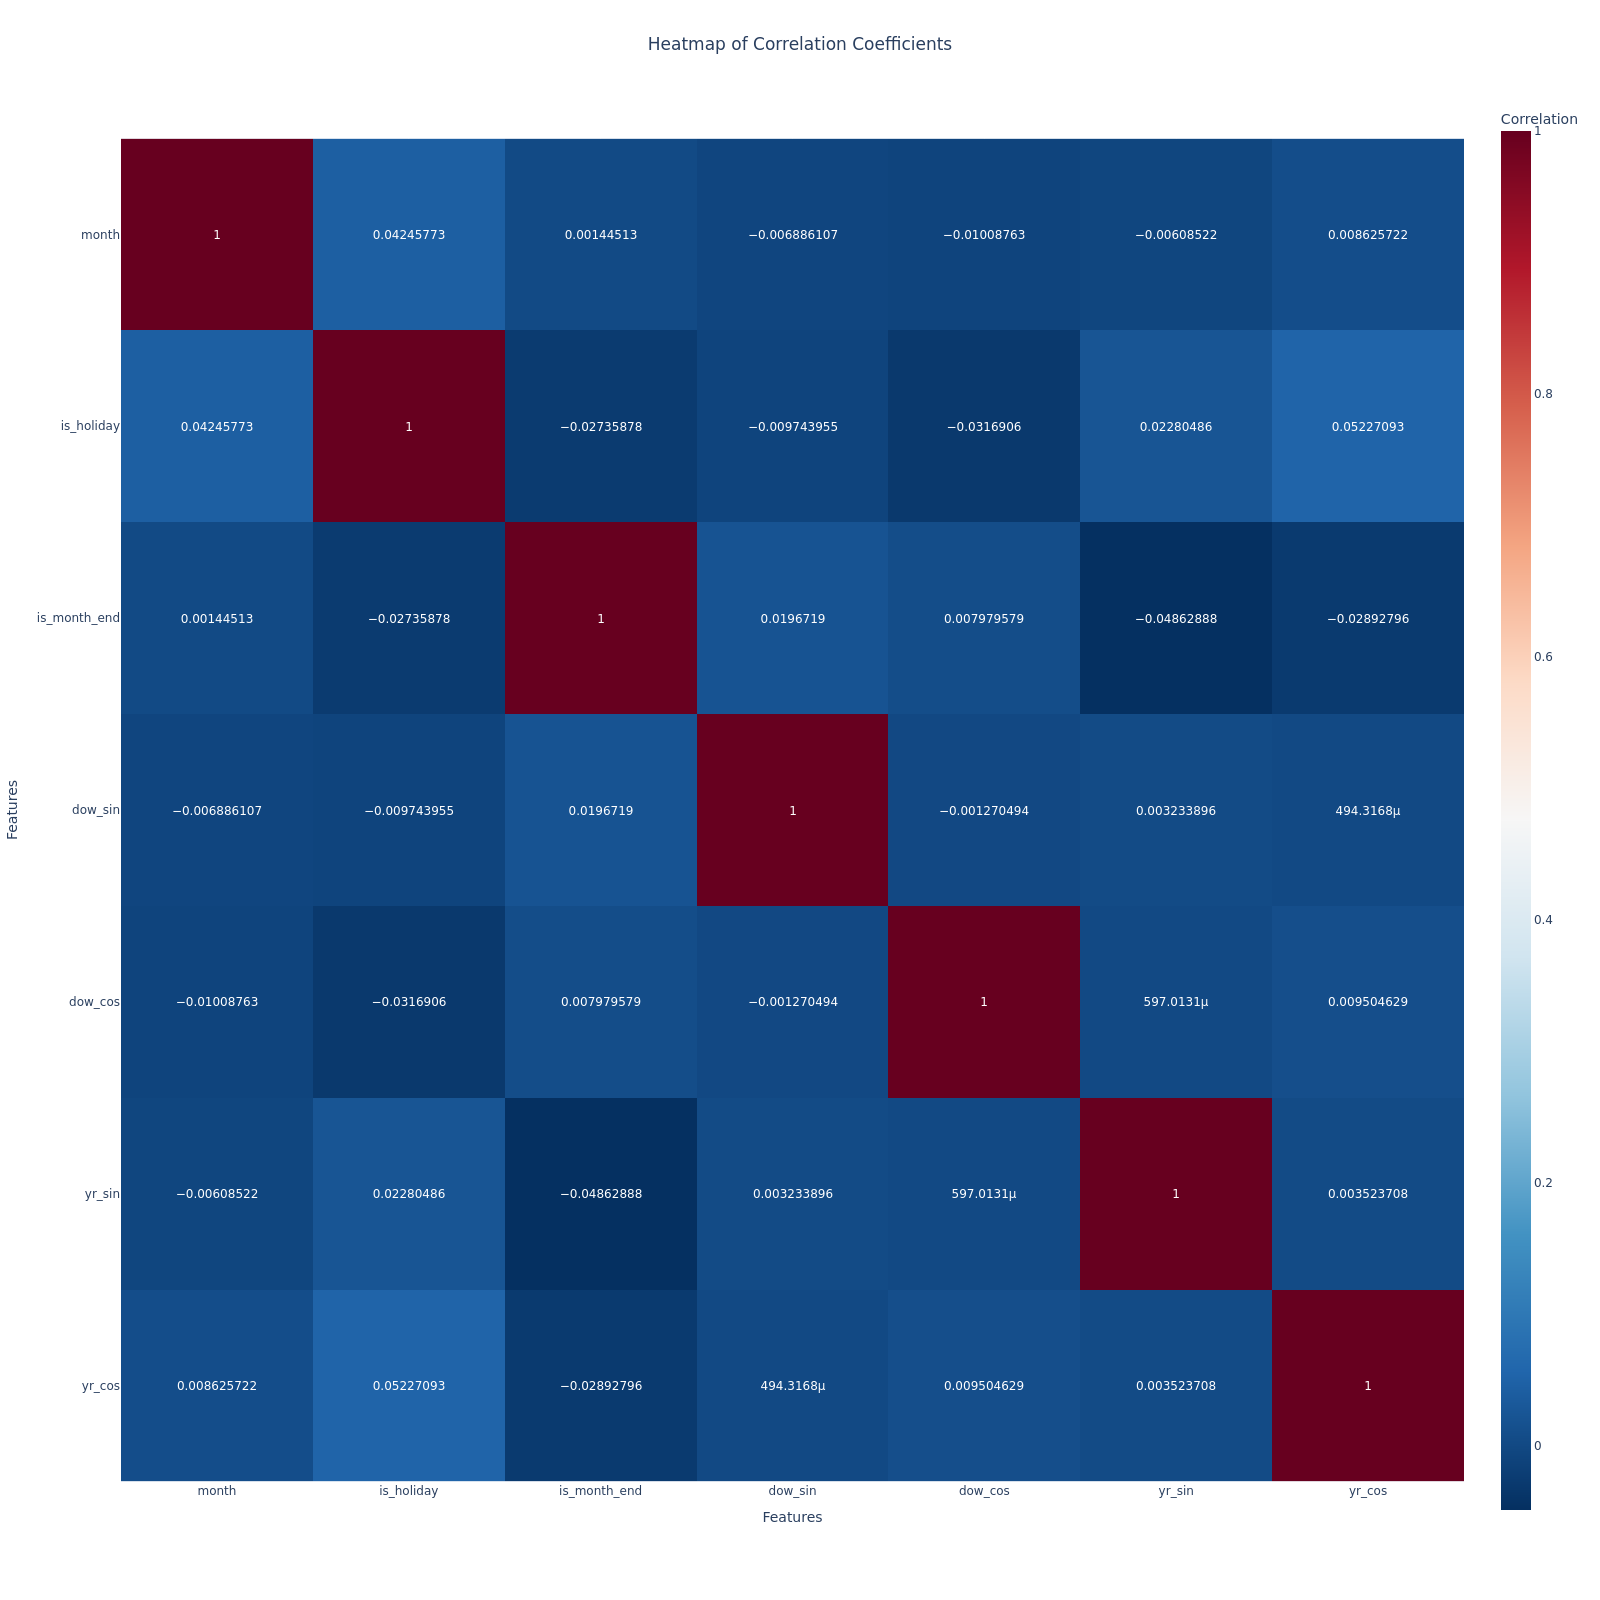

In [ ]:
corr_heatmap(df[df.columns[3:]], fig_type="png")

# Modelagem (Decomposição + Modelagem Residual)

1. modelo estatístico + ML residual
2. ver como fazer Tendência aditivia, sazonalidade multiplicativa
3. ver como fazer tendência aditiva, sazonalidade aditiva